# Libraries and Constants

In [1]:
!pip2 install mne
!pip3 install keras==2.2.5
!pip3 install git+https://www.github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 6.4MB 2.6MB/s 
  Created wheel for mne: filename=mne-0.19.0-cp27-none-any.whl size=6386022 sha256=618991bfaf67ec9e1246e15a2ee775fe35ec5a284e177bd38356af30912feca1
  Stored in directory: /root/.cache/pip/wheels/15/d5/7a/940c9a97748171e859e8baa1549bd5d7bb2f35693bcfd88ff8
Successfully built mne
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-p104w4_2
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-p104w4_2
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=a9188865d7632f75342e871d25e7cdc31aea0e9a732878d5f454aef9160eb8a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gm1_rv1c/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [2]:
 # General
import h5py
import numpy as np
import random
import os
from glob import glob
from tqdm import tqdm

# Modeling and training
from keras import optimizers, losses, activations, models

from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM

from keras_contrib.layers import CRF

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# Data Analisis
import matplotlib.pyplot as plt
import datetime as dt
import collections
import librosa
from scipy.fftpack import fft, fftfreq


WINDOW_SIZE = 100
LENGTH_BASE =3000;
BASE_PATH = "/content/gdrive/My Drive/Classification Waves/eeg_fpz_cz"

from google.colab import drive
drive.mount('/content/gdrive')


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Utils

In [0]:
def print_s(title, data):
  print('_______________________________________________')
  print(data.shape)
  print(title + ':')
  print(data)

  
def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X
  
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X
  
def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_samples = batch_data['x']
        
        batch_size = 10 # until complete the steps_per_epoch
        for i in range(batch_size):
          start_index = random.choice(range(all_samples.shape[0]-WINDOW_SIZE))

          X = all_samples[start_index:start_index+WINDOW_SIZE, ...]
          Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]
          #print_s('Y ANTES', Y)
          #X = np.array([normalization(s) for s in X])
          Y = np.array([stages2(s) for s in Y])
          #print_s('Y DESPUES', Y)
          X = np.expand_dims(X, 0)
          #X = np.expand_dims(X, -1) in tfourier
          Y = np.expand_dims(Y, -1)
          Y = np.expand_dims(Y, 0)

          X = rescale_array(X)
          #print_s('X', X)
         
          yield X,Y
          
def stages2(stage):
  stages = [1,2,3,4,5]
  if stage in stages:
    return 1
  else:
    return 0
  
def normalization(serie):
    scaler = MinMaxScaler(feature_range=(-1, 1)) # between -1,1 because serie has negative values 
    scaler.fit(serie)
    normalized = scaler.transform(serie)
    return normalized
      
def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
  
def tfourier(arr, way = 1 ):
  if(way == 1):
    fourier = np.fft.fft(arr.ravel())
    n =  len(arr.ravel())
    freq = np.fft.rfftfreq(n, 1/100)
    idx = np.argsort(freq)
    aux = np.abs(fourier)**2
    
    #aux[ind_aux[len(aux)-1]] = 0
    #print("ind_aux: ", ind_aux[len(aux)-1])
    #print("frecuencias mas altas: ", freq[idx[len(idx)-1]], aux[idx[len(idx)-1]], freq[idx[len(idx)-2]], aux[idx[len(idx)-2]], freq[idx[len(idx)-3]], aux[idx[len(idx)-3]])
    #aux[idx[len(aux)-1]]=0
    return freq[idx],aux[idx],fourier
  
#list(gen(train_dict, aug=False))
#print(str(stages2(4)))
def plotHistory(model_history, type):
  
  history = model_history.history

  rain_loss = history['loss']
  val_loss   = history['val_loss']
  train_acc  = history['acc']
  val_acc    = history['val_acc']


  fig_h = plt.figure(figsize=(13, 6))
  plt.plot(rain_loss) 
  plt.plot(val_loss) 
  plt.title("Model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.savefig('/content/gdrive/My Drive/Classification Waves/'+type+'/GRAPH_LOSS.png')


  fig_h2 = plt.figure(figsize=(13, 6))


  plt.plot(train_acc) 
  plt.plot(val_acc) 
  plt.title("Model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.savefig('/content/gdrive/My Drive/Classification Waves/'+type+'/GRAPH_ACCURACY.png')

# Graph One Sample

/content/gdrive/My Drive/Classification Waves/eeg_fpz_cz/SC4011E0.npz
shape X
x (1103, 3000, 1)
shape Y
y (1103,)
random_sample
1017
YYYYYYY>
4
_______________________________________________
()
Selected Channel:
b'EEG Fpz-Cz'
_______________________________________________
()
Sampling Rate:
100.0
_______________________________________________
(1103, 3000, 1)
Points:
[[[ -1.7435898]
  [ -2.9391942]
  [ -4.7326007]
  ...
  [-15.293773 ]
  [ -8.020513 ]
  [-20.175825 ]]

 [[-12.1054945]
  [ -8.618315 ]
  [ -8.518682 ]
  ...
  [ 15.1941395]
  [ 14.297436 ]
  [ 12.205129 ]]

 [[ 13.898901 ]
  [ 17.485714 ]
  [ 19.478388 ]
  ...
  [ -1.0461539]
  [ -4.1347985]
  [ -8.419047 ]]

 ...

 [[ -9.714286 ]
  [ -8.518682 ]
  [ -8.419047 ]
  ...
  [  8.120147 ]
  [ 10.810256 ]
  [ 12.703297 ]]

 [[ 17.884249 ]
  [ 26.253479 ]
  [ 31.334799 ]
  ...
  [-30.438095 ]
  [-35.021244 ]
  [-34.02491  ]]

 [[-31.733334 ]
  [-33.427105 ]
  [-30.238829 ]
  ...
  [ -9.515018 ]
  [-12.802931 ]
  [-15.891575 ]]]

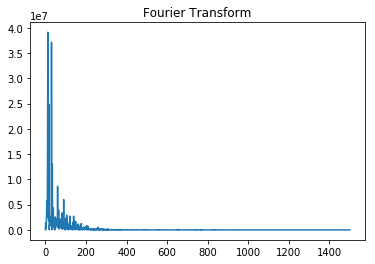

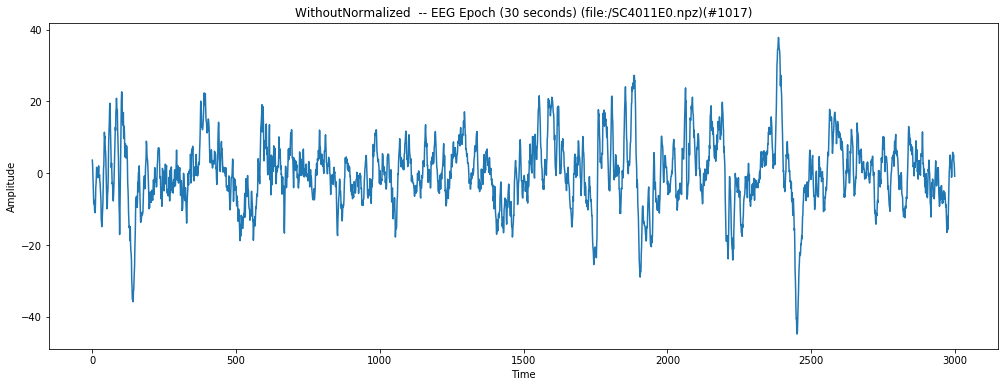

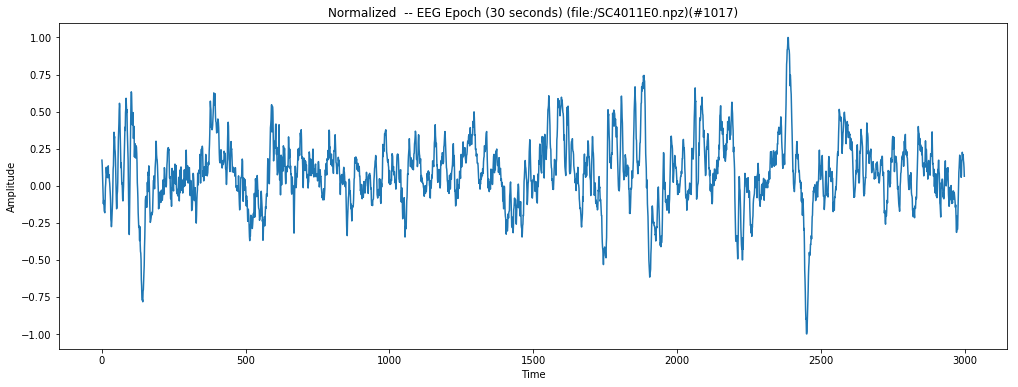

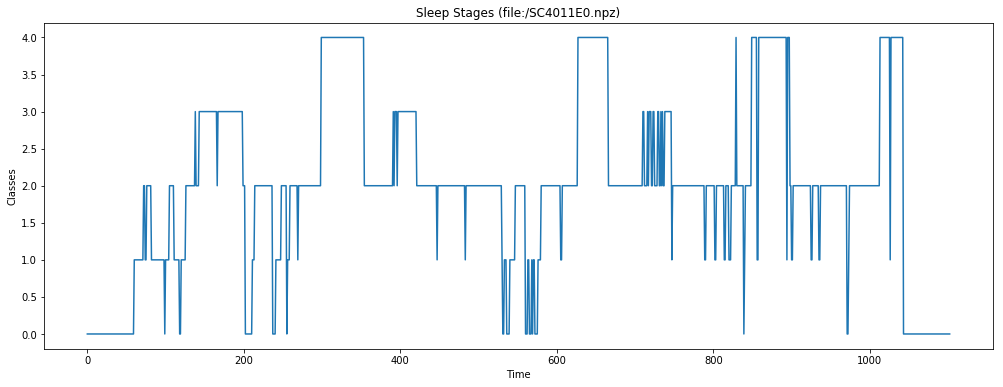

In [4]:
def plot_file(path):
  print(BASE_PATH+path)
  data = np.load(BASE_PATH + path)

  x = data['x']
  y = data['y']
  
  print('shape X')
  print('x', x.shape)
  print('shape Y')
  print('y', y.shape)

  ramdom_sample =random.randrange(y.shape[0])    
  print('random_sample')
  print(ramdom_sample)
  
  list_x = x[ramdom_sample, ...]
  list_y = y[ramdom_sample]
  print('YYYYYYY>')
  print(list_y)
  

  X,Y,Z = tfourier(list_x)
  plt.plot(Y)
  plt.title("Fourier Transform")
  
  fig_1 = plt.figure(figsize=(17, 6))
  plt.plot(list_x.ravel()) # flattened array
  plt.title("WithoutNormalized  -- EEG Epoch (30 seconds) (file:"+ path+ ")(#" + str(ramdom_sample)+ ")")
  plt.ylabel("Amplitude")
  plt.xlabel("Time")
  
  
  fig_2 = plt.figure(figsize=(17, 6))
  normalized = normalization(list_x)
  plt.plot(normalized.ravel()) # flattened array
  plt.title("Normalized  -- EEG Epoch (30 seconds) (file:"+ path+ ")(#" + str(ramdom_sample)+ ")")
  plt.ylabel("Amplitude")
  plt.xlabel("Time")

  fig_3 = plt.figure(figsize=(17, 6))
  plt.plot(y.ravel()) #flattened array
  plt.title("Sleep Stages (file:"+path+")")
  plt.ylabel("Classes")
  plt.xlabel("Time")
  
  
  print_s('Selected Channel',data['ch_label'] )
  print_s('Sampling Rate',data['fs'] )
  print_s('Points',data['x'] )
  print_s('Hypgnogram',data['y'])
  
  

file = "/SC4011E0.npz"
plot_file(file)




# Datasets Generation

**Files are named in the form SC4ssNEO-PSG.edf where 4ss is the subject number, and N is the night. **

In [5]:
base_path = BASE_PATH
print("BASE PATH", base_path);

# Gets and sorts paths from directory
files = sorted(glob(os.path.join(base_path, "*.npz")))

def getIdPerson(path):
  return path.split("/")[-1][:5]

#example test
print("path id person: ", files[0]);
print('example id person: ', getIdPerson(files[0]));

subjects = sorted(list([getIdPerson(x) for x in files]))
print(subjects)

train_ids, test_ids = train_test_split(subjects, test_size=0.2, random_state=1338)

train_group= [x for x in files if getIdPerson(x) in train_ids]
test_subjects = [x for x in files if getIdPerson(x) in test_ids]

print('TOTAL: ' + str(len(test_subjects) +len(train_group) ))
print('TEST_SUBJECTS: '+str(len(test_subjects)))

train_subjects, val_subjects = train_test_split(train_group, test_size=0.4, random_state=1338)

print('TRAIN_SUBJECTS: '+str(len(train_subjects)))
print('VAL_SUBJECTS: '+str(len(val_subjects)))


print('____________________________________________')

# For Training
train_dict = {k: np.load(k) for k in train_subjects}
# For Testing
test_dict = {k: np.load(k) for k in test_subjects}
# For Validation
val_dict = {k: np.load(k) for k in val_subjects}

BASE PATH /content/gdrive/My Drive/Classification Waves/eeg_fpz_cz
path id person:  /content/gdrive/My Drive/Classification Waves/eeg_fpz_cz/SC4001E0.npz
example id person:  SC400
['SC400', 'SC400', 'SC401', 'SC401', 'SC402', 'SC402', 'SC403', 'SC403', 'SC404', 'SC404', 'SC405', 'SC405', 'SC406', 'SC406', 'SC407', 'SC407', 'SC408', 'SC408', 'SC409', 'SC409', 'SC410', 'SC410', 'SC411', 'SC411', 'SC412', 'SC412', 'SC413', 'SC414', 'SC414', 'SC415', 'SC415', 'SC416', 'SC416', 'SC417', 'SC417', 'SC418', 'SC418', 'SC419', 'SC419', 'SC420', 'SC420', 'SC421', 'SC421', 'SC422', 'SC422', 'SC423', 'SC423', 'SC424', 'SC424', 'SC425', 'SC425', 'SC426', 'SC426', 'SC427', 'SC427', 'SC428', 'SC428', 'SC429', 'SC429', 'SC430', 'SC430', 'SC431', 'SC431', 'SC432', 'SC432', 'SC433', 'SC433', 'SC434', 'SC434', 'SC435', 'SC435', 'SC437', 'SC437', 'SC438', 'SC438', 'SC440', 'SC440', 'SC441', 'SC441', 'SC442', 'SC442', 'SC443', 'SC443', 'SC444', 'SC444', 'SC445', 'SC445', 'SC446', 'SC446', 'SC447', 'SC447', 

# Base Models

In [0]:
from keras.utils import plot_model

def get_base_model():
    input_net = Input(shape=(LENGTH_BASE, 1))
    
    output = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(input_net)
    output = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(output)
    output = MaxPool1D(pool_size=2)(output)
    output = SpatialDropout1D(rate=0.01)(output)
    output = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = MaxPool1D(pool_size=2)(output)
    output = SpatialDropout1D(rate=0.01)(output)
    output = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = MaxPool1D(pool_size=2)(output)
    output = SpatialDropout1D(rate=0.01)(output)
    output = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(output)
    output = GlobalMaxPool1D()(output)
    output = Dropout(rate=0.01)(output)

    dense = Dropout(0.01)(Dense(64, activation=activations.relu, name="dense_1")(output))

    base_model = models.Model(inputs=input_net, outputs=dense)
    opt = optimizers.Adam(0.001)

    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #print(base_model.summary())
    return base_model

#plot_model(get_base_model(), to_file='base_model.png', show_shapes=True)


# CNN CRF

In [0]:
# TYPE_RESULT = "CNN_CRF"

# def get_model_cnn_crf(lr=0.001):
#     nclass = 5

#     seq_input = Input(shape=(None, 3000, 1))
#     base_model = get_base_model()
#     # for layer in base_model.layers:
#     #     layer.trainable = False
#     encoded_sequence = TimeDistributed(base_model)(seq_input)
#     encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
#                                                                kernel_size=3,
#                                                                activation="relu",
#                                                                padding="same")(encoded_sequence))
#     encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
#                                                                kernel_size=3,
#                                                                activation="linear",
#                                                                padding="same")(encoded_sequence))

#     #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
#     # out = Convolution1D(nclass, kernel_size=3, activation="linear", padding="same")(encoded_sequence)

#     crf = CRF(nclass, sparse_target=True)

#     out = crf(encoded_sequence)


#     model = models.Model(seq_input, out)

#     model.compile(optimizers.Adam(lr), crf.loss_function, metrics=[crf.accuracy])
#     model.summary()

#     return model


# model3 = get_model_cnn_crf()

# # checkpoint
# filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/weights-improvement-{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = []

# model_history3 = model3.fit_generator(gen(train_dict, aug=False), epochs=100, verbose=1, 
#                      steps_per_epoch=1000, callbacks=callbacks_list, validation_data=gen(val_dict), validation_steps = 300)
# filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/FINAL_MODEL.hdf5"
# model3.save(filepath);
# plotHistory(model_history3, TYPE_RESULT);

# #(muestras, 100, 3000, 1) 
# # (muestras , 100,5)


# CNN LSTM Model

In [0]:
TYPE_RESULT = "CNN_LSTM" 

def get_model_lstm():
    nclass = 5

    seq_input = Input(shape=(None, LENGTH_BASE, 1))
    base_model = get_base_model()
    # for layer in base_model.layers:
    #     layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model

model2 = get_model_lstm()

# checkpoint
filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

model_history2 = model2.fit_generator(gen(train_dict, aug=False), epochs=100, verbose=1, 
                     steps_per_epoch=1000, callbacks=callbacks_list, validation_data=gen(val_dict), validation_steps = 300)
filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/FINAL_MODEL.hdf5"
model2.save(filepath);


history = model_history2.history

rain_loss = history['loss']
val_loss   = history['val_loss']
train_acc  = history['acc']
val_acc    = history['val_acc']


fig_h = plt.figure(figsize=(13, 6))
plt.plot(rain_loss) 
plt.plot(val_loss) 
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig('/content/gdrive/My Drive/Classification Waves/CNN_LSTM/GRAPH_LOSS.png')


fig_h2 = plt.figure(figsize=(13, 6))


plt.plot(train_acc) 
plt.plot(val_acc) 
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig('/content/gdrive/My Drive/Classification Waves/CNN_LSTM/GRAPH_ACCURACY.png')

#(muestras, 100, 3000, 1) 
# (muestras , 100,5)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 3000, 1)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 64)          250416    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         132000    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         240800    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 5)           1005      
Tot

# CNN Model

In [0]:
TYPE_RESULT = "CNN" 
def get_model_cnn():
    nclass = 5

    seq_input = Input(shape=(None, LENGTH_BASE, 1)) # 1 dimensiones
    base_model = get_base_model()
    encoded_sequence = TimeDistributed(base_model)(seq_input) # curring en python
    encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))

    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model
  
model = get_model_cnn()

# checkpoint
filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

model_history = model.fit_generator(gen(train_dict, aug=False), epochs=100, verbose=1, 
                     steps_per_epoch=1000, callbacks=callbacks_list, validation_data=gen(val_dict), validation_steps = 300)
filepath="/content/gdrive/My Drive/Classification Waves/"+TYPE_RESULT+"/FINAL_MODEL.hdf5"
model.save(filepath);



history = model_history.history

rain_loss = history['loss']
val_loss   = history['val_loss']
train_acc  = history['acc']
val_acc    = history['val_acc']


fig_h1 = plt.figure(figsize=(13, 6))
plt.plot(rain_loss) 
plt.plot(val_loss) 
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig('/content/gdrive/My Drive/Classification Waves/CNN/GRAPH_LOSS.png')


fig_h12 = plt.figure(figsize=(13, 6))


plt.plot(train_acc) 
plt.plot(val_acc) 
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig('/content/gdrive/My Drive/Classification Waves/CNN/GRAPH_ACCURACY.png')

#(muestras, 100, 3000, 1) 
# (muestras , 100,5)

# Tests


In [0]:
# import numpy as np
# a = np.array([[
#       [3 ,0.12745282, 0.33755252 ,0.15554342, 0.19395715],
#       [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#     [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#     [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#     [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#      [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#      [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132],
#      [0.1782562 , 0.10877303, 0.39415634, 0.13722312, 0.18159132]
#     ]
#              ])

# # (#muestras, )
# print(a.shape)
# print(a.argmax(axis=-1))
# print(a.argmax(axis=-1).ravel())

# x = np.array(
#      [
#      [1, 2, 3],
#      [2, 2, 4],
#      ]
#     )
# print(x.shape)

# y = np.array(
#     [1, 2, 3]
#     )
# print(y.shape)

# y = np.expand_dims(x, axis=0)
# print(y)
# print(y.shape)
